In [6]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt

start_date = '2001-01-01'
end_date = '2021-09-01'
ticker = 'GOOG'
output_file = ticker.lower() + '_data_' + start_date.replace('-', '') + \
    '_' + end_date.replace('-', '') + '.pkl'


def load_financial_data(start_date, end_date, output_file, ticker):
    try:
        df = pd.read_pickle(output_file)
    except FileNotFoundError:
        df = data.DataReader(ticker, 'yahoo', start_date, end_date)
        df.to_pickle(output_file)

    return df

def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0

    # window_size-days high
    signals['high'] = financial_data['Adj Close'].shift(
        1).rolling(window=window_size).max()
    
    # window_size-days low
    signals['low'] = financial_data['Adj Close'].shift(
        1).rolling(window=window_size).min()
    
    # window_size-days mean
    signals['avg'] = financial_data['Adj Close'].shift(
        1).rolling(window=window_size).mean()

    # entry rule : stock price > the higest value for window_size day
    #              stock price < the lowest value for window_size day
    signals['long_entry'] = financial_data['Adj Close'] > signals.high
    signals['short_entry'] = financial_data['Adj Close'] < signals.low

    #exit rule : the stock price crosses the mean of past window_size days.
    signals['long_exit'] = financial_data['Adj Close'] < signals.avg
    signals['short_exit'] = financial_data['Adj Close'] > signals.avg

    position = 0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position == 0:
            signals.orders.values[k] = 1
            position = 1
        elif signals['short_entry'][k] and position == 0:
            signals.orders.values[k] = -1
            position = -1
        elif signals['short_exit'][k] and position > 0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals

In [7]:
data = load_financial_data(start_date, end_date, output_file, ticker)

In [8]:
ts = turtle_trading(data, 50)

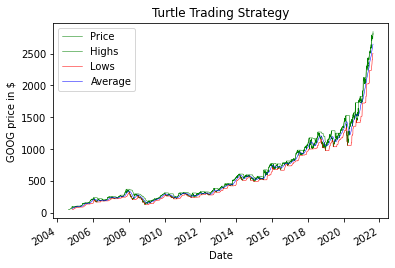

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel=f'{ticker} price in $')
data["Adj Close"].plot(ax=ax1, color='g', lw=.5)
ts["high"].plot(ax=ax1, color='g', lw=.5)
ts["low"].plot(ax=ax1, color='r', lw=.5)
ts["avg"].plot(ax=ax1, color='b', lw=.5)

ax1.plot(ts.loc[ts.orders == 1.0].index,
         data["Adj Close"][ts.orders == 1.0],
         '^', markersize=7, color='k')

ax1.plot(ts.loc[ts.orders == -1.0].index,
         data["Adj Close"][ts.orders == -1.0],
         'v', markersize=7, color='k')

plt.legend(["Price", "Highs", "Lows", "Average", "Buy", "Sell"])
plt.title("Turtle Trading Strategy")

plt.show()